In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [3]:
from icecream import ic
import csv
filename = '/../Academics/Semester7/BTP/Algo_Modification_TestCases/Data.csv'

# Functions Required

In [4]:
def get_margins(mu, N, M, t, T, delta):
    # delta = 0.1
    val1 = N*(M+1)/2/delta
    val2 = t**3
    val = val1*val2
    # print(val)
    log_term = math.log(val)
    sqrt_term = log_term/2/T
    alpha = math.sqrt(sqrt_term)
    LCB = mu - alpha
    UCB = mu + alpha
    return LCB, UCB

In [5]:
def get_feasible_set(mu_th, UCB_attr):
    ## mu_attr will be an array with the current means of all attributes of the specific arm
    ## same for UCB and LCB things
    feasible_set = []
    ## here mu_attr would be a 2D array with all the means
    ## same for LCB (LCB_attr)
    n = len(UCB_attr)
    m = len(UCB_attr[0])
    for i in range (n):
        ## for each arm
        found = False
        UCB_min = min(UCB_attr[i])
        if (UCB_min >= mu_th):
            feasible_set.append(i)

    return feasible_set

In [6]:
def get_perfect_feasible_set(mu_th, LCB_attr):
    feasible_set = []
    ## here mu_attr would be a 2D array with all the means
    ## same for LCB (LCB_attr)
    # n = len(LCB_attr)
    n = len(LCB_attr)
    for i in range (n):
        ## for each arm
        LCB_min  = min(LCB_attr[i])
        if (LCB_min >= mu_th):
            feasible_set.append(i)

    return feasible_set

In [7]:
def get_potential_set(i_star_t, LCB_i_star, UCB):
    ## here UCB will be an array for UCB of means of all the arms
    potent = []
    for i in range(len(UCB)):
        if ((LCB_i_star <= UCB[i]) and (i != i_star_t)):
            potent.append(i)
    return potent

In [8]:
def best_arm(mu, feasible_set):
    ## for arms in feasible set, we need to find the arm with maximum mean
    # if len(feasible_set) == 0: return 0
    best = feasible_set[0]
    for arm in feasible_set:
        if(mu[arm] >= mu[best]):
            best = arm
    return best

In [9]:
def intersection(lst1, lst2):
    temp = set(lst2)
    lst3 = [value for value in lst1 if value in temp]
    return lst3

In [10]:
def potentially_competitor_arm(UCB, feasible_set, potentially_best_arm):
    if (potentially_best_arm != feasible_set[0]):
        best = feasible_set[0]
    else:
        best = feasible_set[1]
    for arm in feasible_set:
        if (arm != potentially_best_arm):
            if((UCB[arm] > UCB[best])):
                best = arm
    # print("pot: ", potentially_best_arm, "ct: ", best)
    return best

In [11]:
def get_suboptimal_arm(mu_i_star, mu_i, arms_set):
    suboptimal = []
    for arms in arms_set:
        if (mu_i[arms] < mu_i_star):
            suboptimal.append(arms)

    return suboptimal

In [12]:
def difference(li1, li2):
    s = set(li2)
    temp3 = [x for x in li1 if x not in s]
    return temp3

In [13]:
def get_perfect_feasible_attr_set(mu_th, LCB_attr):
    perfect_feasible = []
    for i in range (len(LCB_attr)):
        for j in range (len(LCB_attr[0])):
            if LCB_attr[i][j] >= mu_th:
                perfect_feasible.append([i, j])

    return perfect_feasible

In [14]:
def get_possibly_feasible_attr_set(mu_th, LCB_attr, UCB_attr):
    ans = []
    # N, M = len(LCB_attr), len(UCB_attr)
    # print(N, M)
    for i in range(len(LCB_attr)):
        for j in range (len(UCB_attr[0])):
            if LCB_attr[i][j] < mu_th and UCB_attr[i][j] >= mu_th:
                ans.append([i, j])
    return ans

# Oracle

In [135]:
class Oracle:
    def __init__(self, M, N, mu_th) -> None:
        self.M = M
        self.N = N
        arms = 5
        attributes = 5
        self.mu_ij = [[0 for i in range (attributes)] for j in range (arms)]
        self.ab_array = [[[0, 0] for i in range (attributes)] for j in range (arms)]
        self.mu_i = [0 for i in range (arms)]

        self.mu_th = mu_th
        
        ## fixing alpha at 1

        self.ab_array[0] = np.array([[1, 1], [1, 0.67], [1, 0.67], [1, 1], [1, 0.25]])            #0.6
        self.ab_array[1] = np.array([[1, 0.43], [1, 1], [1, 1.5], [1, 1.5], [1, 0.67]])          #0.58
        self.ab_array[2] = np.array([[1, (1/x)-1], [1, 1], [1, 0.11], [1, 0.25], [1, 0.11]])         #0.68
        self.ab_array[3] = np.array([[1, 0.67], [1, 4], [1, 1.5], [1, 0.43], [1, 0.67]])          #0.5
        self.ab_array[4] = np.array([[1, 2.33], [1, 0.43], [1, 1.5], [1, 0.11], [1, 1]])          #0.56

        for i in range (arms):
            for j in range (attributes):
                alpha = self.ab_array[i][j][0]
                beta = self.ab_array[i][j][1]
                self.mu_ij[i][j] = alpha / (alpha + beta)


        for i in range (len(self.mu_i)):
            self.mu_i[i] = sum(self.mu_ij[i])/attributes

    def play(self, arm, attr):
        alpha, beta = self.ab_array[arm][attr]
        reward = np.random.beta(alpha, beta, 1)[0]
        return reward
    
    def hardness(self):
        self.i_star = 0                 ## best arm in the feasible set
        self.i_star_star = self.N            ## best arm in suboptimal set

        self.delta_i = [0 for i in range (self.N)]
        self.delta_ij = [[0 for i in range (self.M)] for j in range (self.N)]
        self.delta_i_attr = [0 for i in range (self.N)]

         ### assume that always i_star is 0 ###
        
        all_arms = list(range(0, self.N))

        self.perfect_feasible = get_perfect_feasible_set(self.mu_th, self.mu_ij)
        self.i_star = best_arm(self.mu_i, self.perfect_feasible)

        self.suboptimal = get_suboptimal_arm(self.mu_i[self.i_star], self.mu_i, all_arms)
        if len(self.suboptimal) != 0:
            self.i_star_star = best_arm(self.mu_i, self.suboptimal)
        
        self.risky = difference(all_arms, self.suboptimal)
        self.infeasible = difference(all_arms, self.perfect_feasible) 

        for i in range (self.N):
            if (i != self.i_star):
                self.delta_i[i] = self.mu_i[self.i_star] - self.mu_i[i]
                self.delta_i_attr[i] = abs(min(self.mu_ij[i]) - self.mu_th)

        if self.i_star_star < self.N:                                                                           ### the suboptimal set has elements greater than zero
            self.delta_i[self.i_star] = self.delta_i[self.i_star_star]
        else:
            self.delta_i[self.i_star] = math.inf
            
        self.delta_i_attr[self.i_star] = abs(min(self.mu_ij[self.i_star]) - self.mu_th)

        return self.delta_i[self.i_star], self.delta_i_attr
    
    def H_index(self):
        self.i_star = 0                 ## best arm in the feasible set
        self.i_star_star = self.N            ## best arm in suboptimal set

        self.delta_i = [0 for i in range (self.N)]
        self.delta_ij = [[0 for i in range (self.M)] for j in range (self.N)]
        self.delta_i_attr = [0 for i in range (self.N)]

         ### assume that always i_star is 0 ###
        
        all_arms = list(range(0, self.N))

        self.perfect_feasible = get_perfect_feasible_set(self.mu_th, self.mu_ij)
        self.i_star = best_arm(self.mu_i, self.perfect_feasible)

        self.suboptimal = get_suboptimal_arm(self.mu_i[self.i_star], self.mu_i, all_arms)
        if len(self.suboptimal) != 0:
            self.i_star_star = best_arm(self.mu_i, self.suboptimal)
        
        self.risky = difference(all_arms, self.suboptimal)
        self.infeasible = difference(all_arms, self.perfect_feasible) 

        for i in range (self.N):
            if (i != self.i_star):
                self.delta_i[i] = self.mu_i[self.i_star] - self.mu_i[i]
                self.delta_i_attr[i] = abs(min(self.mu_ij[i]) - self.mu_th)

        if self.i_star_star < self.N:                                                                           ### the suboptimal set has elements greater than zero
            self.delta_i[self.i_star] = self.delta_i[self.i_star_star]
        else:
            self.delta_i[self.i_star] = math.inf
        self.delta_i_attr[self.i_star] = abs(min(self.mu_ij[self.i_star]) - self.mu_th)
        # print(self.delta_i_attr)

        self.set1 = intersection(self.perfect_feasible, self.suboptimal)
        self.set2 = intersection(self.infeasible, self.risky)
        self.set3 = intersection(self.infeasible, self.suboptimal)

        h0_den = (min(self.delta_i[self.i_star]/2, self.delta_i_attr[self.i_star]))**2
        h0 = 1/h0_den

        h1 = 0
        for i in self.set1:
            h1 += 4/(self.delta_i[i])**2

        h2 = 0
        for i in self.set2:
            h2 += 1/(self.delta_i_attr[i])**2

        h3 = 0
        for i in self.set3:
            h3 += 1/(max(self.delta_i[i]/2, self.delta_i_attr[i]))**2

        h_index = h0 + h1 + h2 + h3

        return h_index

# Main Function 

In [93]:
def game(M, N, mu_th, delta):
    T_t_attr = [[0 for i in range (M)] for j in range (N)]
    T_t = [0 for i in range(N)]
    # t = 1
    theGame = Oracle(M, N, mu_th)

    h_idx, h_idx_old = 0, 0
    # h_idx_old = theGame.H_index_old()
    
    
    h_idx = theGame.H_index()


    delta_i, delta_i_attr = theGame.hardness()

    mu_hat_i = [0 for i in range (N)]
    mu_hat_ij = [[0 for i in range (M)] for j in range (N)]

    LCB = [0 for i in range (N)]
    UCB = [0 for i in range (N)]
    alpha = [0 for i in range (N)]

    LCB_attr = [[0 for i in range (M)] for j in range (N)]
    UCB_attr = [[0 for i in range (M)] for j in range (N)]

    T_unif = 20

    for j in range (T_unif):
        ## 20 times uniform exploration
        for i in range (N):
            for k in range (M):
                reward_arm = theGame.play(i, k)
                mu_hat_ij[i][k] = (mu_hat_ij[i][k] * T_t_attr[i][k] + reward_arm)/(T_t_attr[i][k] + 1)
                T_t_attr[i][k] += 1
            mu_hat_i[i] = sum(mu_hat_ij[i])/M
            # T_t[i] = sum(T_t_attr[i])
            T_t[i] = min(T_t_attr[i])
            

    all_arms = list(range(0, N))
    feasible = list(range(0, N))
    t = N*T_unif*M

    ### further pulls

    while(True):
        ## arm wise margins
        for i in range (N):
            LCB[i], UCB[i] = get_margins(mu_hat_i[i], N, M, t, T_t[i], delta)
            alpha[i] = mu_hat_i[i] - LCB[i]

        ## attribute wise margins
        for i in range (N):
            for j in range (M):
                LCB_attr[i][j], UCB_attr[i][j] = get_margins(mu_hat_ij[i][j], N, M, t, T_t_attr[i][j], delta)

        # print("t: ", t, "T: ", T_t, "alpha: ", alpha, "mu: ", mu_hat_i)

        perfect_feasible = get_perfect_feasible_set(mu_th, LCB_attr)
        feasible = get_feasible_set(mu_th, UCB_attr)

        perfect_feasible_attr = get_perfect_feasible_attr_set(mu_th, LCB_attr)                  ## this is the surely feasible set
        possibly_feasible_attr = get_possibly_feasible_attr_set(mu_th, LCB_attr, UCB_attr)               ## this is the dell f set
        feasible_attr = []
        for elem in perfect_feasible_attr:
            feasible_attr.append(elem)
        for elem in possibly_feasible_attr:
            feasible_attr.append(elem)
        ### here each entry will be an array with values [arm, attr]

        if(len(perfect_feasible) != 0):
            i_star_t = best_arm(mu_hat_i, perfect_feasible)
        else:
            i_star_t = mu_hat_i.index(max(mu_hat_i))

        if (len(feasible) != 0):
            i_t = best_arm(mu_hat_i, feasible)

        ## potential set is the set of arms which have more UCB than the  current best arm mean, irrespective of feasibility
        if (len(perfect_feasible) == 0):
            potential = all_arms
        else:
            potential = get_potential_set(i_star_t, LCB[i_star_t], UCB)
        
        pot_intersect_feas = intersection(potential, feasible)

        # print("Feasible: ", feasible, "Perfect feasible: ", perfect_feasible, "Potential: ", potential, "mu_hat for all", mu_hat_i, "UCB of all: ", UCB, "LCB for all: ", LCB)
        # print("Feasible: ", feasible, "Attribute feasible: ", possibly_feasible_attr, "Potential: ", potential, "i_t:", i_t, "alpha: ", alpha, "T_t: ", T_t, "T_t_attr: ", T_t_attr)
        #  "i_t: ", i_t, "i_star: ", i_star_t,
        # ic(feasible, perfect_feasible, potential, mu_hat_i, alpha, i_t)
        


        ## Stopping criteria
        if (len(pot_intersect_feas) == 0):
            if(len(perfect_feasible) == 0):
                f_hat = 0
                i_out = N
            else:
                f_hat = 1
                i_out = i_t
            return i_out, f_hat, t, h_idx_old, h_idx, delta_i, delta_i_attr
        

        ################################# Sampling criteria here ####################################3
        def original_algo():
            # print(T_t_attr)
            t1 = [sum(T_t_attr[i]) for i in range (N)]
            t = sum(t1)
            # print(t)
            if (len(feasible) == 1):
                i_t = best_arm(mu_hat_i, difference(feasible, perfect_feasible))
                t_copy = t
                for arm, attr in feasible_attr:
                    if arm == i_t:
                        ### pull arm, attr
                        reward = theGame.play(arm, attr)
                        mu_hat_ij[arm][attr] = (mu_hat_ij[arm][attr] * T_t_attr[arm][attr] + reward)/(T_t_attr[arm][attr] + 1)
                        T_t_attr[arm][attr] += 1
                        t += 1

                mu_hat_i[i_t] = sum(mu_hat_ij[i_t])/M
                # T_t[i_t] = sum(T_t_attr[i_t])
                T_t[i_t] = min(T_t_attr[i_t])

            else:
                i_t = best_arm(mu_hat_i, feasible)
                c_t = potentially_competitor_arm(UCB, feasible, i_t)
                # print("else part")
                # print("Feasible: ", feasible, "Attribute Possibly feasible: ", possibly_feasible_attr, "Attribute feasible: ", feasible_attr, "Potential: ", potential, "i_t:", i_t, "c_t: ", c_t, "alpha: ", alpha, "T_t: ", T_t, "T_t_attr: ", T_t_attr, "UCB: ", UCB)
                # print("Feasible: ", feasible, "Perfect feasible: ", perfect_feasible, "possibly feasible attr: ", possibly_feasible_attr, "i_t: ", i_t, "i_star: ", i_star_t)
                # t_copy = t
                # for arm, attr in possibly_feasible_attr:
                for arm, attr in feasible_attr:
                    if arm == i_t or arm == c_t:
                        ### pull arm, attr
                        reward = theGame.play(arm, attr)
                        mu_hat_ij[arm][attr] = (mu_hat_ij[arm][attr] * T_t_attr[arm][attr] + reward)/(T_t_attr[arm][attr] + 1)
                        T_t_attr[arm][attr] += 1
                        t += 1

                mu_hat_i[i_t] = sum(mu_hat_ij[i_t])/M
                mu_hat_i[c_t] = sum(mu_hat_ij[c_t])/M
                # T_t[i_t] = sum(T_t_attr[i_t])
                # T_t[c_t] = sum(T_t_attr[c_t])

                T_t[i_t] = min(T_t_attr[i_t])
                T_t[c_t] = min(T_t_attr[c_t])

            return t

        def modified_algo():
            # print(T_t)
            # print(t)
            t1 = [sum(T_t_attr[i]) for i in range (N)]
            t = sum(t1)
            if (len(feasible) == 1):
                # print("if case")
                i_t = best_arm(mu_hat_i, difference(feasible, perfect_feasible))
                t_copy = t
                for arm, attr in possibly_feasible_attr:
                    # if arm == i_t:
                        ### pull arm, attr
                    reward = theGame.play(arm, attr)
                    mu_hat_ij[arm][attr] = (mu_hat_ij[arm][attr] * T_t_attr[arm][attr] + reward)/(T_t_attr[arm][attr] + 1)
                    T_t_attr[arm][attr] += 1
                    t += 1
                    
                arm = i_t
                for attr in range (M):
                    reward = theGame.play(arm, attr)
                    mu_hat_ij[arm][attr] = (mu_hat_ij[arm][attr] * T_t_attr[arm][attr] + reward)/(T_t_attr[arm][attr] + 1)
                    T_t_attr[arm][attr] += 1
                    t += 1

                mu_hat_i[i_t] = sum(mu_hat_ij[i_t])/M
                # T_t[i_t] = sum(T_t_attr[i_t])
                T_t[i_t] = min(T_t_attr[i_t])

            else:
                i_t = best_arm(mu_hat_i, feasible)
                c_t = potentially_competitor_arm(UCB, feasible, i_t)
                # print("else part")
                # print("Feasible: ", feasible, "Attribute Possibly feasible: ", possibly_feasible_attr, "Attribute feasible: ", feasible_attr, "Potential: ", potential, "i_t:", i_t, "c_t: ", c_t, "alpha: ", alpha, "T_t: ", T_t, "T_t_attr: ", T_t_attr, "UCB: ", UCB)
                # print("Feasible: ", feasible, "Perfect feasible: ", perfect_feasible, "possibly feasible attr: ", possibly_feasible_attr, "i_t: ", i_t, "i_star: ", i_star_t)
                t_copy = t
                # for arm, attr in possibly_feasible_attr:
                for arm, attr in possibly_feasible_attr:
                    reward = theGame.play(arm, attr)
                    mu_hat_ij[arm][attr] = (mu_hat_ij[arm][attr] * T_t_attr[arm][attr] + reward)/(T_t_attr[arm][attr] + 1)
                    T_t_attr[arm][attr] += 1
                    t += 1
                    mu_hat_i[arm] = sum(mu_hat_ij[arm])/M
                    T_t[arm] = min(T_t_attr[arm])

                ### pulling all attributes of i_t and c_t
                arm = i_t
                for attr in range (M):
                    reward = theGame.play(arm, attr)
                    mu_hat_ij[arm][attr] = (mu_hat_ij[arm][attr] * T_t_attr[arm][attr] + reward)/(T_t_attr[arm][attr] + 1)
                    T_t_attr[arm][attr] += 1
                    t += 1
                arm = c_t
                for attr in range (M):
                    reward = theGame.play(arm, attr)
                    mu_hat_ij[arm][attr] = (mu_hat_ij[arm][attr] * T_t_attr[arm][attr] + reward)/(T_t_attr[arm][attr] + 1)
                    T_t_attr[arm][attr] += 1
                    t += 1

                mu_hat_i[i_t] = sum(mu_hat_ij[i_t])/M
                mu_hat_i[c_t] = sum(mu_hat_ij[c_t])/M
                # T_t[i_t] = sum(T_t_attr[i_t])
                # T_t[c_t] = sum(T_t_attr[c_t])

                T_t[i_t] = min(T_t_attr[i_t])
                T_t[c_t] = min(T_t_attr[c_t])

            return t

        ########################## conditions and algos to use ##############################
        ## if we discover the existance of an arm which is infeasible and has highest mean empirically, we should go with the modification algo
        best_mean_arm = mu_hat_i.index(max(mu_hat_i))
        # print(feasible)
        # print(mu_hat_i, best_mean_arm, perfect_feasible)
        # print(best_mean_arm in perfect_feasible)
        if best_mean_arm in perfect_feasible:
            # print("modified")
            t = original_algo()
        else:
            # print("original")
            t = modified_algo()

# Testcases

### Case 3

In [ ]:
# self.mu_ij[0] = np.array([0.5, 0.6, 0.6, 0.5, 0.8])               #0.6
#         self.mu_ij[1] = np.array([0.7, 0.5, 0.4, 0.4, 0.6])        #0.58
#         self.mu_ij[2] = np.array([x, 0.5, 0.9, 0.8, 0.9])        #0.68
#         self.mu_ij[3] = np.array([0.6, 0.2, 0.4, 0.7, 0.6])        #0.5
#         self.mu_ij[4] = np.array([0.3, 0.7, 0.4, 0.9, 0.5])        #0.56

# self.ab_array[0] = np.array([[1, 1], [1, 0.67], [1, 0.67], [1, 1], [1, 0.25]])            #0.6
# self.ab_array[1] = np.array([[1, 0.43], [1, 1], [1, 1.5], [1, 1.5], [1, 0.67]])          #0.58
# self.ab_array[2] = np.array([[1, (1/x)-1], [1, 1], [1, 0.11], [1, 0.25], [1, 0.11]])         #0.68
# self.ab_array[3] = np.array([[1, 0.67], [1, 4], [1, 1.5], [1, 0.43], [1, 0.67]])          #0.5
# self.ab_array[4] = np.array([[1, 2.33], [1, 0.43], [1, 1.5], [1, 0.11], [1, 1]])          #0.56

# mu_th = 0.35

# x varies from 0.05 to 0.34

In [136]:
N = 5
M = 5
N_iter = 10
delta_ins = 0.1

samples_ins = []
x_val = []
time_bound = []
prob_success = []

for x in [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]:
# for x in [0.05]:
    count = [0 for i in range (N+1)]
    samples_all = []
    for i in range (N_iter):
        best_arm_guess, f, samples, h_idx_old, h_idx, delta_i, delta_i_attr = game(M, N, mu_th=0.35, delta=delta_ins)
        samples_all.append(samples)
        count[best_arm_guess] += 1

    samples_ins.append(sum(samples_all)/N_iter)
    # x_val.append(x)
    x_val.append(h_idx)
    time = h_idx * math.log(h_idx/delta_ins)
    time_bound.append(time)
    prob_success.append(count[0]/N_iter)
    print("Done")


Done
Done
Done
Done
Done
Done


In [137]:
print(prob_success)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [138]:
print(x_val)
print(samples_ins)

[3660.99655226773, 3665.8854411566185, 3674.8854411566185, 3694.329885601063, 3749.8854411566185, 4049.8854411566185]
[184812.8, 183333.9, 182811.7, 186892.0, 185864.8, 211586.6]


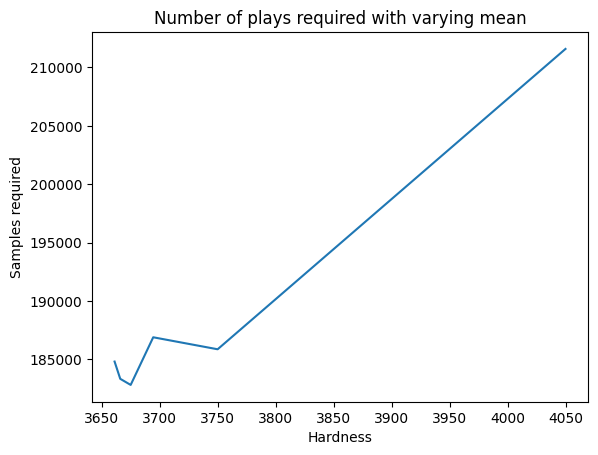

In [139]:
plt.title("Number of plays required with varying mean")
plt.xlabel("Hardness")
plt.ylabel("Samples required")
plt.plot(x_val, samples_ins)
plt.show()

### Case 4a

In [103]:
# self.mu_ij[0] = np.array([0.5, 0.6, 0.6, 0.5, 0.8])               #0.6
#         self.mu_ij[1] = np.array([0.7, 0.5, 0.4, 0.4, 0.6])        #0.58
#         self.mu_ij[2] = np.array([x, 0.5, 0.4, 0.8, 0.4])        #0.68
#         self.mu_ij[3] = np.array([0.6, 0.2, 0.4, 0.7, 0.6])        #0.5
#         self.mu_ij[4] = np.array([0.3, 0.7, 0.4, 0.9, 0.5])        #0.56

# self.ab_array[0] = np.array([[1, 1], [1, 0.67], [1, 0.67], [1, 1], [1, 0.25]])            #0.6
# self.ab_array[1] = np.array([[1, 0.43], [1, 1], [1, 1.5], [1, 1.5], [1, 0.67]])          #0.58
# self.ab_array[2] = np.array([[1, (1/x)-1], [1, 1], [1, 1.5], [1, 0.25], [1, 1.5]])         #0.68
# self.ab_array[3] = np.array([[1, 0.67], [1, 4], [1, 1.5], [1, 0.43], [1, 0.67]])          #0.5
# self.ab_array[4] = np.array([[1, 2.33], [1, 0.43], [1, 1.5], [1, 0.11], [1, 1]])          #0.56

# mu_th = 0.35

# x varies from 0.05 to 0.28

In [130]:
N = 5
M = 5
N_iter = 10
delta_ins = 0.1

samples_ins = []
x_val = []
time_bound, time_bound_old = [], []
prob_success = []

for x in [0.05, 0.1, 0.15, 0.2, 0.25]:
    count = [0 for i in range (N+1)]
    samples_all = []
    for i in range (N_iter):
        best_arm_guess, f, samples, h_id_old, h_id, delta_i, delta_i_attr = game(M, N, mu_th=0.35, delta=delta_ins)
        samples_all.append(samples)
        count[best_arm_guess] += 1

    samples_ins.append(sum(samples_all)/N_iter)
    # x_val.append(x)
    x_val.append(h_id)
    # print(h_idx)
    # time_old = h_id_old * math.log(h_id_old/delta_ins)
    time = h_id * math.log(h_id/delta_ins)
    # time_bound_old.append(time_old)
    time_bound.append(time)
    prob_success.append(count[0]/N_iter)
    print("Done")


Done
Done
Done
Done
Done


In [131]:
print(prob_success)

[1.0, 1.0, 1.0, 1.0, 1.0]


In [132]:
print(x_val)
print(samples_ins)

[3660.9965522677294, 3665.8854411566185, 3674.8854411566185, 3694.329885601063, 3749.8854411566185]
[188399.8, 185655.9, 192212.4, 188339.6, 203399.3]


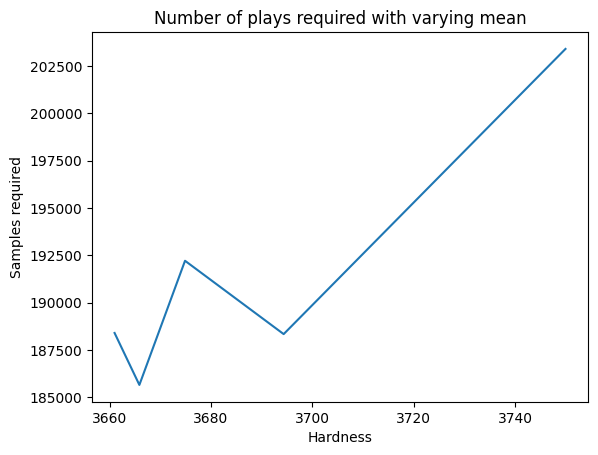

In [133]:
plt.title("Number of plays required with varying mean")
plt.xlabel("Hardness")
plt.ylabel("Samples required")
plt.plot(x_val, samples_ins)
plt.show()

### Case 4b

In [ ]:
# self.mu_ij[0] = np.array([0.5, 0.6, 0.6, 0.5, 0.8])               #0.6
#         self.mu_ij[1] = np.array([0.7, 0.5, 0.4, 0.4, 0.6])        #0.58
#         self.mu_ij[2] = np.array([0.3, 0.5, 0.4, 0.8, x])        #0.68
#         self.mu_ij[3] = np.array([0.34, 0.34, 0.8, 0.7, 0.5])        #0.5
#         self.mu_ij[4] = np.array([0.34, 0.7, 0.4, 0.9, 0.5])        #0.56  

# self.ab_array[0] = np.array([[1, 1], [1, 0.67], [1, 0.67], [1, 1], [1, 0.25]])            #0.6
# self.ab_array[1] = np.array([[1, 0.43], [1, 1], [1, 1.5], [1, 1.5], [1, 0.67]])          #0.58
# self.ab_array[2] = np.array([[1, 2.33], [1, 1], [1, 1.5], [1, 0.25], [1, (1/x)-1]])         #0.68
# self.ab_array[3] = np.array([[1, 1.94], [1, 1.94], [1, 0.25], [1, 0.43], [1, 1]])          #0.5
# self.ab_array[4] = np.array([[1, 1.94], [1, 0.43], [1, 1.5], [1, 0.11], [1, 1]])          #0.56

# mu_th = 0.35

# x varies from 0.05 to 0.34

In [123]:
N = 5
M = 5
N_iter = 5
delta_ins = 0.1

samples_ins = []
x_val = []
time_bound, time_bound_old = [], []
prob_success = []

# for x in [0.36, 0.38, 0.4, 0.42, 0.44, 0.46, 0.48]:
# for x in [0.36, 0.38, 0.4, 0.42, 0.44, 0.45]:
# for x in [0.4, 0.42, 0.44, 0.45]:
for x in [0.36, 0.39, 0.42, 0.45, 0.48]:
    count = [0 for i in range (N+1)]
    samples_all = []
    for i in range (N_iter):
        best_arm_guess, f, samples, h_id_old, h_id, delta_i, delta_i_attr = game(M, N, mu_th=0.35, delta=delta_ins)
        samples_all.append(samples)
        count[best_arm_guess] += 1

    samples_ins.append(sum(samples_all)/N_iter)
    # x_val.append(x)
    x_val.append(h_id)
    # time_old = h_id_old * math.log(h_id_old/delta_ins)
    time = h_id * math.log(h_id/delta_ins)
    # time_bound_old.append(time_old)
    time_bound.append(time)
    prob_success.append(count[0]/N_iter)
    print("Done")


Done
Done
Done
Done
Done


In [124]:
print(prob_success)

[1.0, 1.0, 1.0, 1.0, 1.0]


In [125]:
print(x_val)
print(samples_ins)

[9947.834411980708, 9972.760105121502, 10001.671791249817, 10035.466982530681, 10075.310792638411]
[1050911.4, 1006397.6, 1056204.4, 1057704.4, 1046059.6]


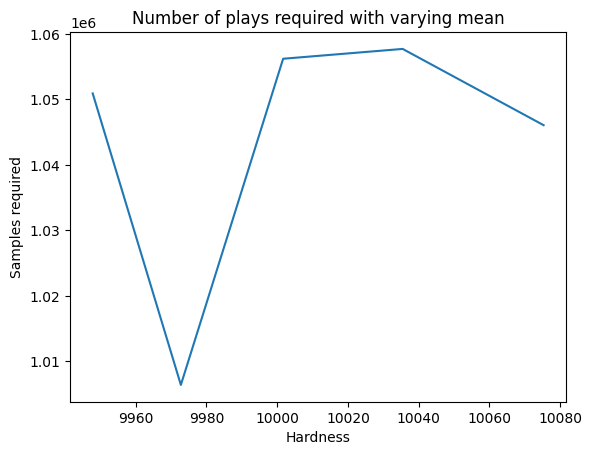

In [126]:
plt.title("Number of plays required with varying mean")
plt.xlabel("Hardness")
plt.ylabel("Samples required")
plt.plot(x_val, samples_ins)
plt.show()

# Plotting

In [140]:
with open(filename, 'r') as file:
    # Create a CSV reader object
    reader = csv.reader(file)

    # Create a list to store the rows
    rows = []

    # Iterate over each row in the CSV file
    for row in reader:
        # Append the row to the list
        rows.append(row)

    # Modify the 4th row
    # print(len(rows))
    rows[0] = x_val
    rows[3] = samples_ins

# Open the CSV file in write mode
with open(filename, 'w', newline='') as file:
    # Create a CSV writer object
    writer = csv.writer(file)

    # Write the modified rows to the CSV file
    writer.writerows(rows)